In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
### IMPORT STATEMENTS ###

import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
!pip install category_encoders==2.*
from category_encoders import OrdinalEncoder, OneHotEncoder

     |████████████████████████████████| 82 kB 350 kB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Wrangling

The first hurdle to analyzing any data is putting it into a usable form. I am going to do some minor tweaks and readjustments of the dataset to clean it up to my liking.

In [3]:
def wrangle(filepath):
  df = pd.read_csv(filepath, index_col='Num')

  #remove null values from Type2 col
  df['Type2'] = df['Type2'].fillna(value=df['Type1'])

  #add new features
  df['Power'] = df['HP'] + df['Attack'] + df['Defense'] + df['SpAtk'] + df['SpDef'] + df['Speed']

  

  return df

In [4]:
df = wrangle('/content/drive/MyDrive/PokemonData.csv')


In [5]:
df.head()

,Name,Type1,Type2,HP,Attack,Defense,SpAtk,SpDef,Speed,Generation,Legendary,Power
Num,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,318
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,405
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,525
3,VenusaurMega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,625
4,Charmander,Fire,Fire,39,52,43,60,50,65,1,False,309


## Selecting a Target Variable
After reading in and looking at my DataFrame, I saw that the variable I wanted to test on did not exist, so I will have to create it. I want my target variable to be the Pokémon's total power, the sum of all of its battle traits. To do this, I will create a new feature in the DataFrame that is the sum of the 'HP', 'Attack', 'Defense', 'SpAtk', 'SpDef', and 'Speed' columns. 

Of course, my model will be able to very accurately predict a Pokémon's power by its other stats, given that power is literally just a sum of the other stats, so I will have to remove the other stats from my feature matrix in order to avoid data leakage.

## Regression or Classification?
Because the target variable, the sum of the Pokémon's attribute values, is quantitative, I'll use a regression model. Since I will be one-hot encoding my variables, I will use a Ridge regression model to help curb overfitting.

## Distribution


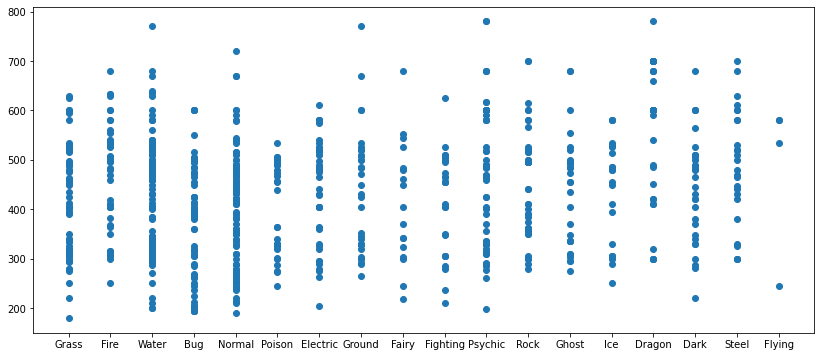

In [12]:
plt.figure(figsize=(14, 6))
plt.scatter(df['Type1'], df['Power'])



After checking the Power distribution for the Type1 and Type2 columns, they both appear to be evenly distributed. My original plan of trying to estimate a Pokémon's power based on its type may not be very effective, but it will be interesting to see what we can discover.

## Metrics and Baseline
I am the most familiar with using the Mean Absolute Error, so I will be using that to judge my model's performance.

In [16]:
X = df[['Type1', 'Type2', 'Generation', 'Legendary']]
y = df['Power']
y_pred = [df['Power'].mean()] * len(y)

baseline_mae = mean_absolute_error(y, y_pred)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 100.26564375


I can see that my baseline isn't great. Being off by an average of 100 points when most of the values are in the 300-400 point range isn't ideal, but at least it means my model won't have to be particularly mindblowing to beat the baseline.

## Splitting the Data
I'm going to use a randomized train-test split just in case there's a difference between the power of Pokémon released in newer generations versus older ones. I thought about excluding Legendary Pokémon from the pool, but decided to leave them in because on the whole, they're not actually much stronger than some fully-evolved Pokémon. Thus, I am comfortable in knowing that they will not skew my data too much.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)


## Building the Model

In [19]:
model_r = make_pipeline(OneHotEncoder(),
                         SimpleImputer(),
                         Ridge())
                         
    
    

model_r.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Type1', 'Type2'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=False,
                               verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [22]:
model_r_mae = mean_absolute_error(y_test, model_r.predict(X_test))
print('Ridge Regression Model MAE:', model_r_mae)

Ridge Regression Model MAE: 89.36293962229914


##Awesome!
It looks like my regression model beats my baseline score by around 11 points, which sounds great until you remember that the baseline score is literally just guessing... let's see what a tree-based model can do for us.

In [23]:
model_rf = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(),
                         RandomForestRegressor())
model_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Type1', 'Type2'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'Type1',
                                          'data_type': dtype('O'),
                                          'mapping': Ground       1
Psychic      2
Fighting     3
Ice          4
Bug          5
Rock         6
Fire         7
Steel        8
Poison       9
Normal      10
Dark        11
Ghost       12
Water       13
Grass       14
Electric    15
Dragon      16
Fairy       17
Flying      18
NaN         -2
dtype: int64},
                                         {...
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                     

In [24]:
model_rf_mae = mean_absolute_error(y_test, model_rf.predict(X_test))
print('Random Forest Regression Model MAE:', model_rf_mae)

Random Forest Regression Model MAE: 97.21765799959613


Somehow my tree-based model did worse than the Ridge regression model, which was really a surprise for me. I will be doing some more tuning on the Ridge model to see if I can get it to be more accurate.